# **Домашнее задание №1 (base)**

В этом домашнем задании вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;
* реализовать веб-сервис для применения построенной модели на новых данных

**Максимальная оценка за дз**
> Оценка за домашку = $min(\text{ваш балл}, 11)$

**Мягкий дедлайн: 27 ноября 23:59**

**Жесткий дедлайн: 20 декабря 23:59 (конец модуля)**


**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [45]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from ydata_profiling import ProfileReport

%matplotlib inline

random.seed(42)
np.random.seed(42)

**Задание 0 (0 баллов).**
Для чего фиксируем сиды в домашках?

`Your answer here`

# **Часть 1 | EDA и визуализация**

Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (2.5 балла)
- Визуализации признаков и их анализ (1 балл)

Всего можно набрать 3.5 основных балла и 0.65 бонусных. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (2.5 балла)**

In [46]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1 (0.55 балла)**

Выполните операции, направленные на практику основных действий с `pandas`:
- [ ] Отобразите 10 случайных строк тренировочного датасета (0.15 балла)
- [ ] Отобразите первые 5 и последние 5 объектов тестового датасета (0.1 балла)
- [ ] Посмотрите, есть ли в датасете пропуски. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)


**Бонус**
- [ ] Постройте дашборд, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)

In [47]:
print(df_train.sample(n=10))
print(df_test.head())
print(df_test.tail())
missing_columns_test = df_test.columns[df_test.isnull().any()]
missing_columns_train = df_train.columns[df_train.isnull().any()]
print("Колонки с пропущенными значениями в df_test:")
print(missing_columns_test)
print("Колонки с пропущенными значениями в df_train:")
print(missing_columns_train)

profile = ProfileReport(df_test, title="Дашборд", explorative=True)
profile.to_notebook_iframe()


                                        name  year  selling_price  km_driven  \
6565        Renault KWID Climber 1.0 MT BSIV  2019         300000      35000   
2943                      Maruti Wagon R LXI  2013         225000      58343   
2024                    Hyundai i20 Asta 1.2  2013         360000      30000   
263                     Hyundai i20 1.2 Asta  2010         300000      70000   
4586        Skoda Octavia L and K 1.9 TDI MT  2005         250000     120000   
4479                         Maruti Ciaz ZXi  2016         700000      20000   
4881  Hyundai Grand i10 1.2 Kappa Magna BSIV  2017         445000      27000   
3583          Ford Ecosport 1.5 DV5 MT Trend  2016         515000      68609   
6361                  Hyundai Verna 1.4 VTVT  2014         500000      33400   
4108                     Hyundai i20 Era 1.2  2015         490000      45900   

        fuel       seller_type transmission         owner     mileage  \
6565  Petrol        Individual       Manual   

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Мы обнаружили пропуски. Давайте избавимся от них.

- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось. Заполнение пропусков проводите для обоих наборов данных, если необходимо

**Важно!**

При заполнении пропусков и в тестовом, и тренировочном наборах данных вы определяетесь со стратегией предобработки пропущенных значений при потенциальной работе модели.

Так как в теоретическом случае вы не имеете доступа к тестовой выборке, то заполняемой значение (у нас — медиана) вы считаете про *тренировочному* набору данных и им же заполняете *тестовый*.

In [48]:
def normalize_data_variables(data):
    data['mileage'] = data['mileage'].apply(lambda x: normalize_mileage(x))
    data['engine'] = data['engine'].apply(lambda x: float(x.split(' ')[0]) if type(x) != float else x)
    data.loc[data['max_power'] == ' bhp', 'max_power'] = np.nan
    data.loc[data['max_power'] == '0', 'max_power'] = np.nan
    data['max_power'] = data['max_power'].apply(lambda x: float(x.split(' ')[0]) if type(x) != float else x)
    data['torque'] = data['torque'].apply(lambda x: normalize_torque(x))
    return data


def normalize_mileage(x):
    if type(x) != float:
        return float(x.split(' ')[0]) if x.split(' ')[1] == 'kmpl' else float(x.split(' ')[0]) * 1.4
    else:
        return x


def normalize_max_power(x):
    if type(x) != float:
        return float(x.split(' ')[0]) if x.split(' ')[1] == 'kmpl' else float(x.split(' ')[0]) * 1.4
    else:
        return x


def normalize_torque(torque):
    torque = str(torque)
    match = re.match(r"([\d\.]+)\s*(kgm|Nm)", torque)
    if match:
        value = float(match.group(1))
        type_value = match.group(2)
        if type_value == 'kgm':
            value *= 9.81
        return value
    return None


df_test = normalize_data_variables(df_test)
df_train = normalize_data_variables(df_train)
median_mileage = df_train['mileage'].median()
median_engine = df_train['engine'].median()
median_max_power = df_train['max_power'].median()
median_seats = df_train['seats'].median()
median_torque = df_train['torque'].median()

df_train['mileage'] = df_train['mileage'].fillna(median_mileage)
df_train['engine'] = df_train['engine'].fillna(median_engine)
df_train['max_power'] = df_train['max_power'].fillna(median_max_power)
df_train['seats'] = df_train['seats'].fillna(median_seats)
df_train['torque'] = df_train['seats'].fillna(median_torque)

df_test['mileage'] = df_train['mileage'].fillna(median_mileage)
df_test['engine'] = df_train['engine'].fillna(median_engine)
df_test['max_power'] = df_train['max_power'].fillna(median_max_power)
df_test['seats'] = df_train['seats'].fillna(median_seats)
df_test['torque'] = df_test['seats'].fillna(median_torque)

print("Пропуски в df_train:")
print(df_train.isnull().sum())

print("Пропуски в df_test:")
print(df_test.isnull().sum())


Пропуски в df_train:
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64
Пропуски в df_test:
name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64


### **Задание 2 (0.5 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.1 балла)
- [ ] Отобразите такие объекты (0.15 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.15 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.1 балла)


In [49]:
duplicates = df_train.drop(['selling_price'], axis=1).duplicated()
if duplicates.any():
    print('Дубликатов: ', duplicates.sum())

df_train[duplicates]

df_train = df_train.groupby(df_train.drop(columns=['selling_price']).columns.tolist(), as_index=False).first()

df_train = df_train.reset_index(drop=True)

Дубликатов:  1159


In [50]:
assert df_train.shape == (5840, 13)

Отлично! Мы избавились от маленьких и явных проблем. Теперь перейдем к более сложным недостаткам полученной таблицы.

### **Задание 3 (0.25 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Удалите столбец ``torque``


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.
- Стобец ``torque`` мы удаляем для простоты. В идеальном случае, его также стоило бы предобработать.

In [51]:
# Переработано выше, в конце первого задания

### **Задание 4 (0.1 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.

In [105]:
df_train['engine'] = df_train['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)

df_test['engine'] = df_test['engine'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

### **Задание 5 (0.1 балла)**

Отлично! Мы провели "косметическую" предобработку и теперь готовы сделать важный шаг в контексте анализа данных. А именно — посмотреть на статистики!

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

**Примечание:**

Более корректно рассматривать статистики до заполнения пропусков и после, чтобы убедиться, что мы не внесли каких-либо серьезных сдвигов в изначальные рапсределения.

In [53]:
df_train.describe()
df_test.describe()

df_train.describe(include=object)
df_test.describe(include=object)

name    fuel seller_type transmission        owner
count                  1000    1000        1000         1000         1000
unique                  621       4           3            2            5
top     Maruti Alto 800 LXI  Diesel  Individual       Manual  First Owner
freq                     15     534         837          877          623

In [54]:
assert df_train.shape == (5840, 13)

## **Визуализации (1 балл + 0.5 бонус)**



Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 6 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

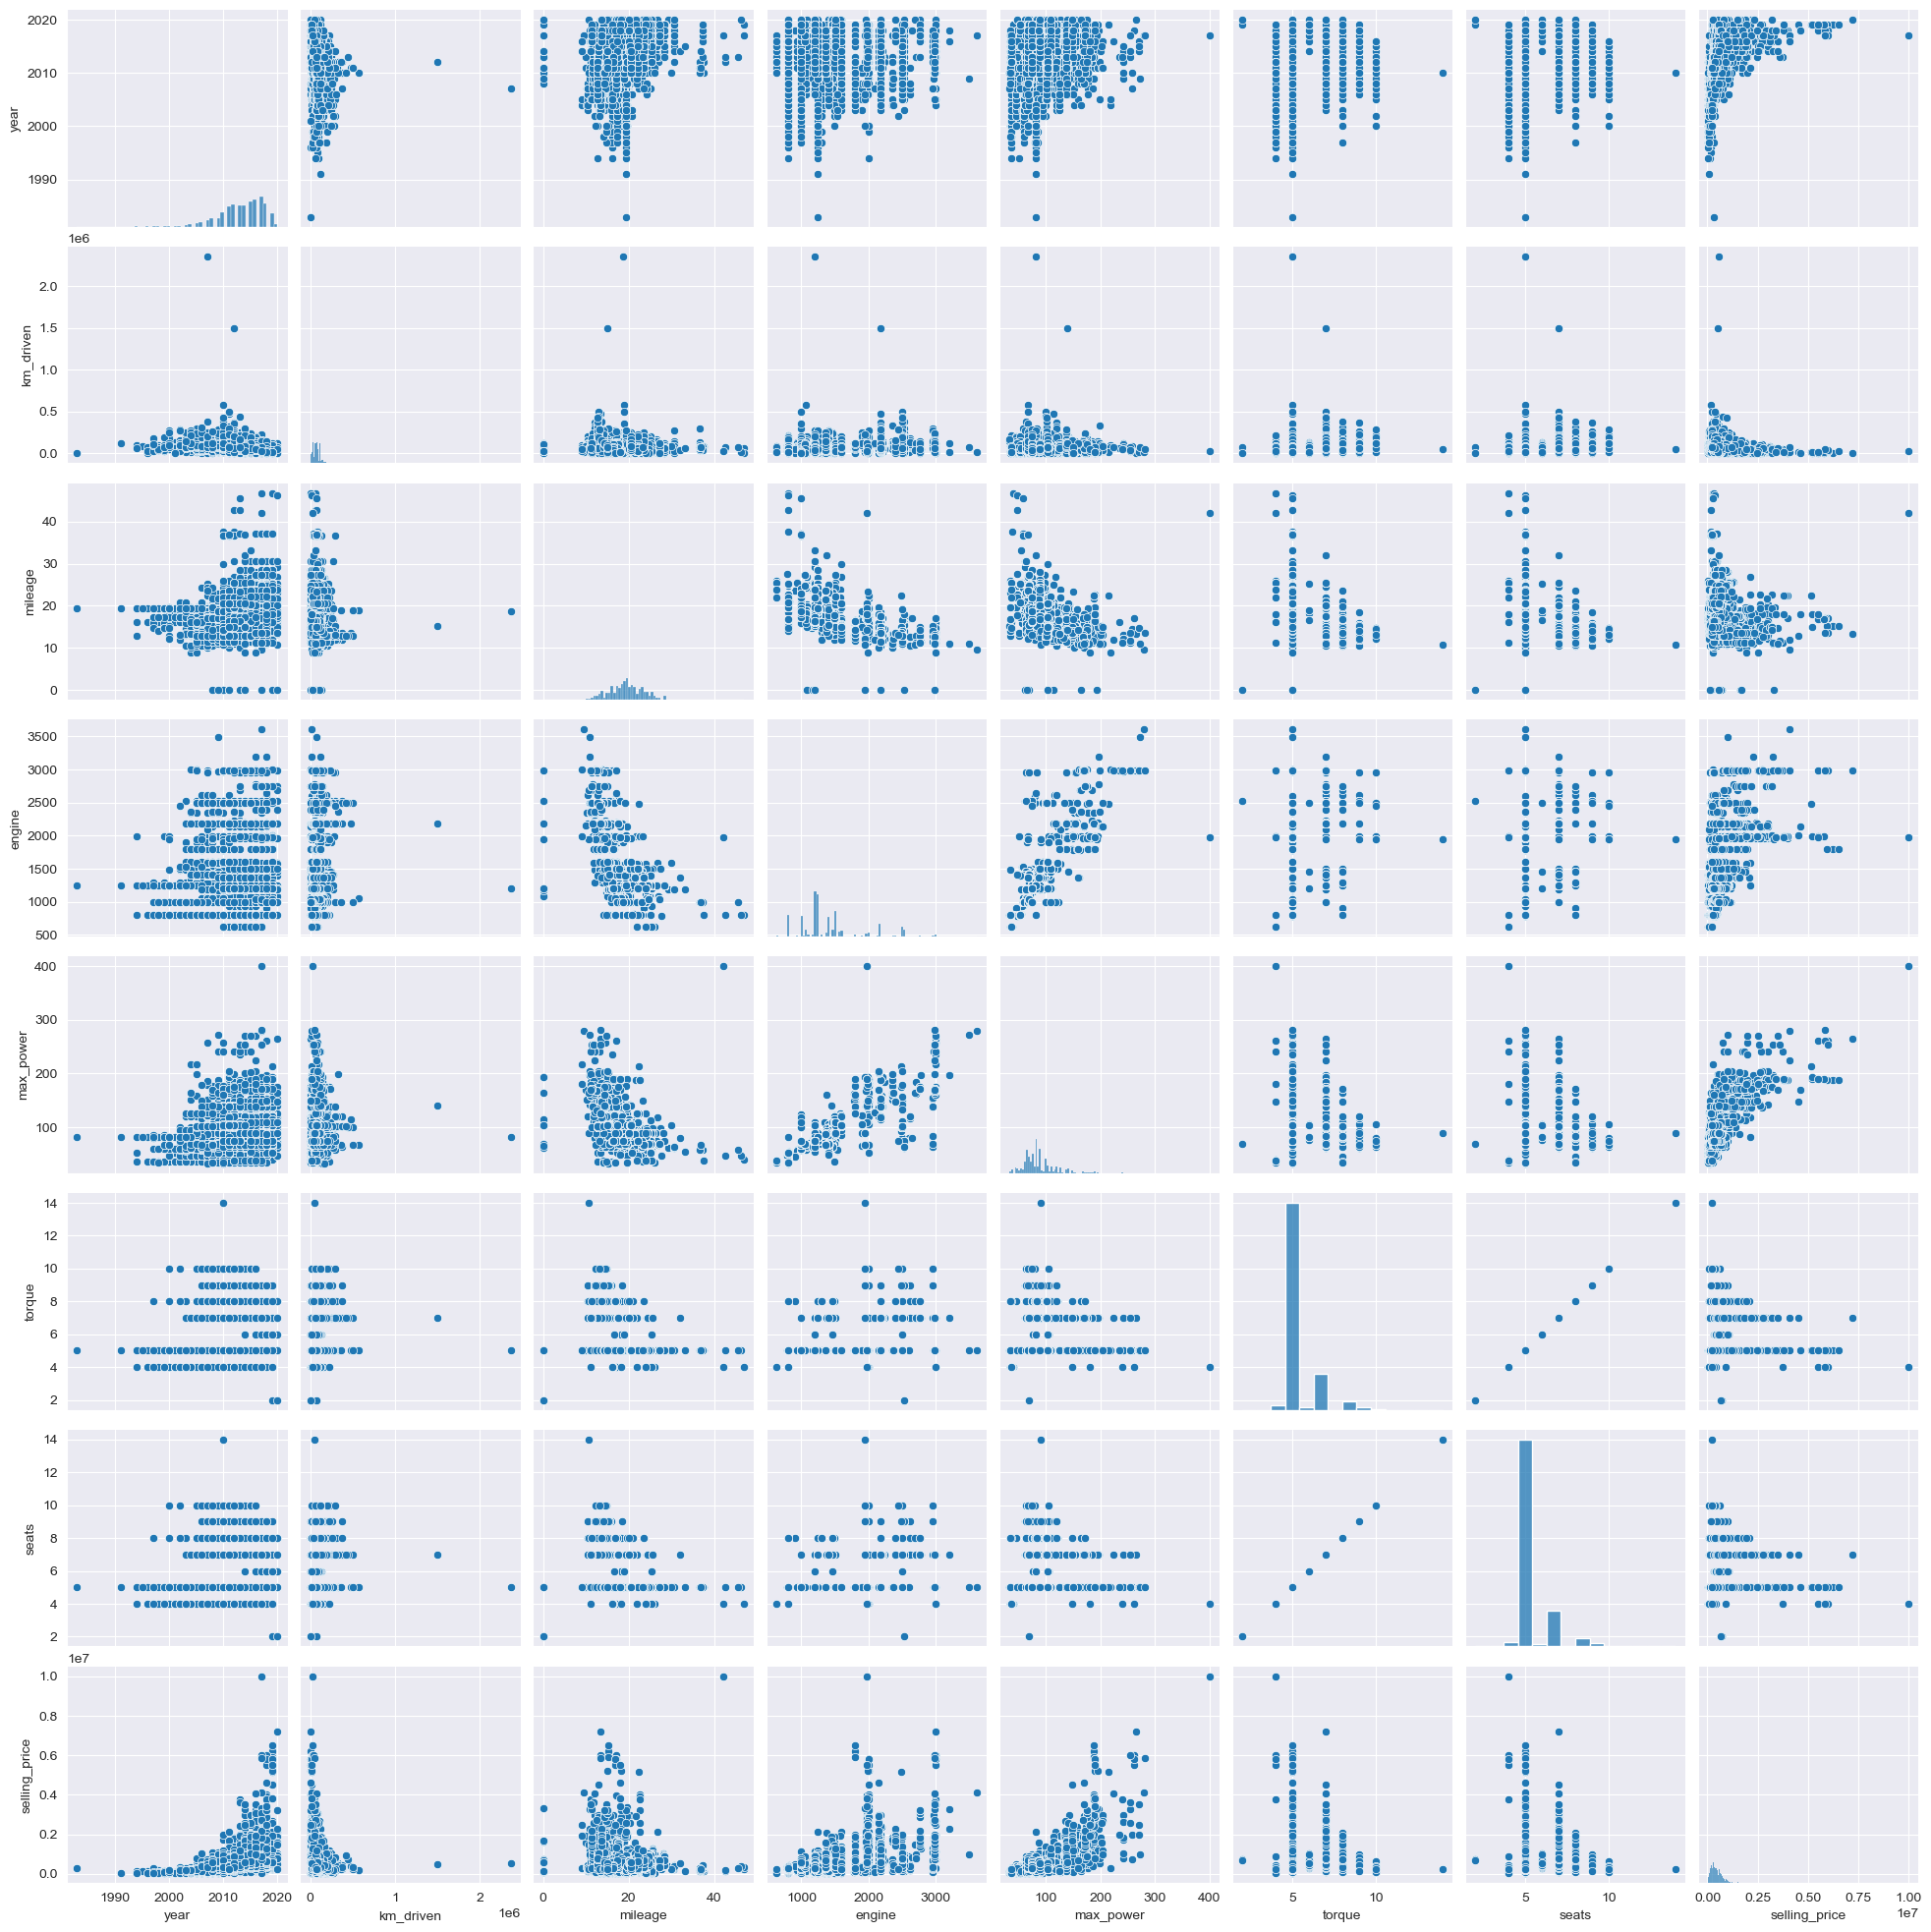

In [55]:
sns.pairplot(df_train)
plt.show()

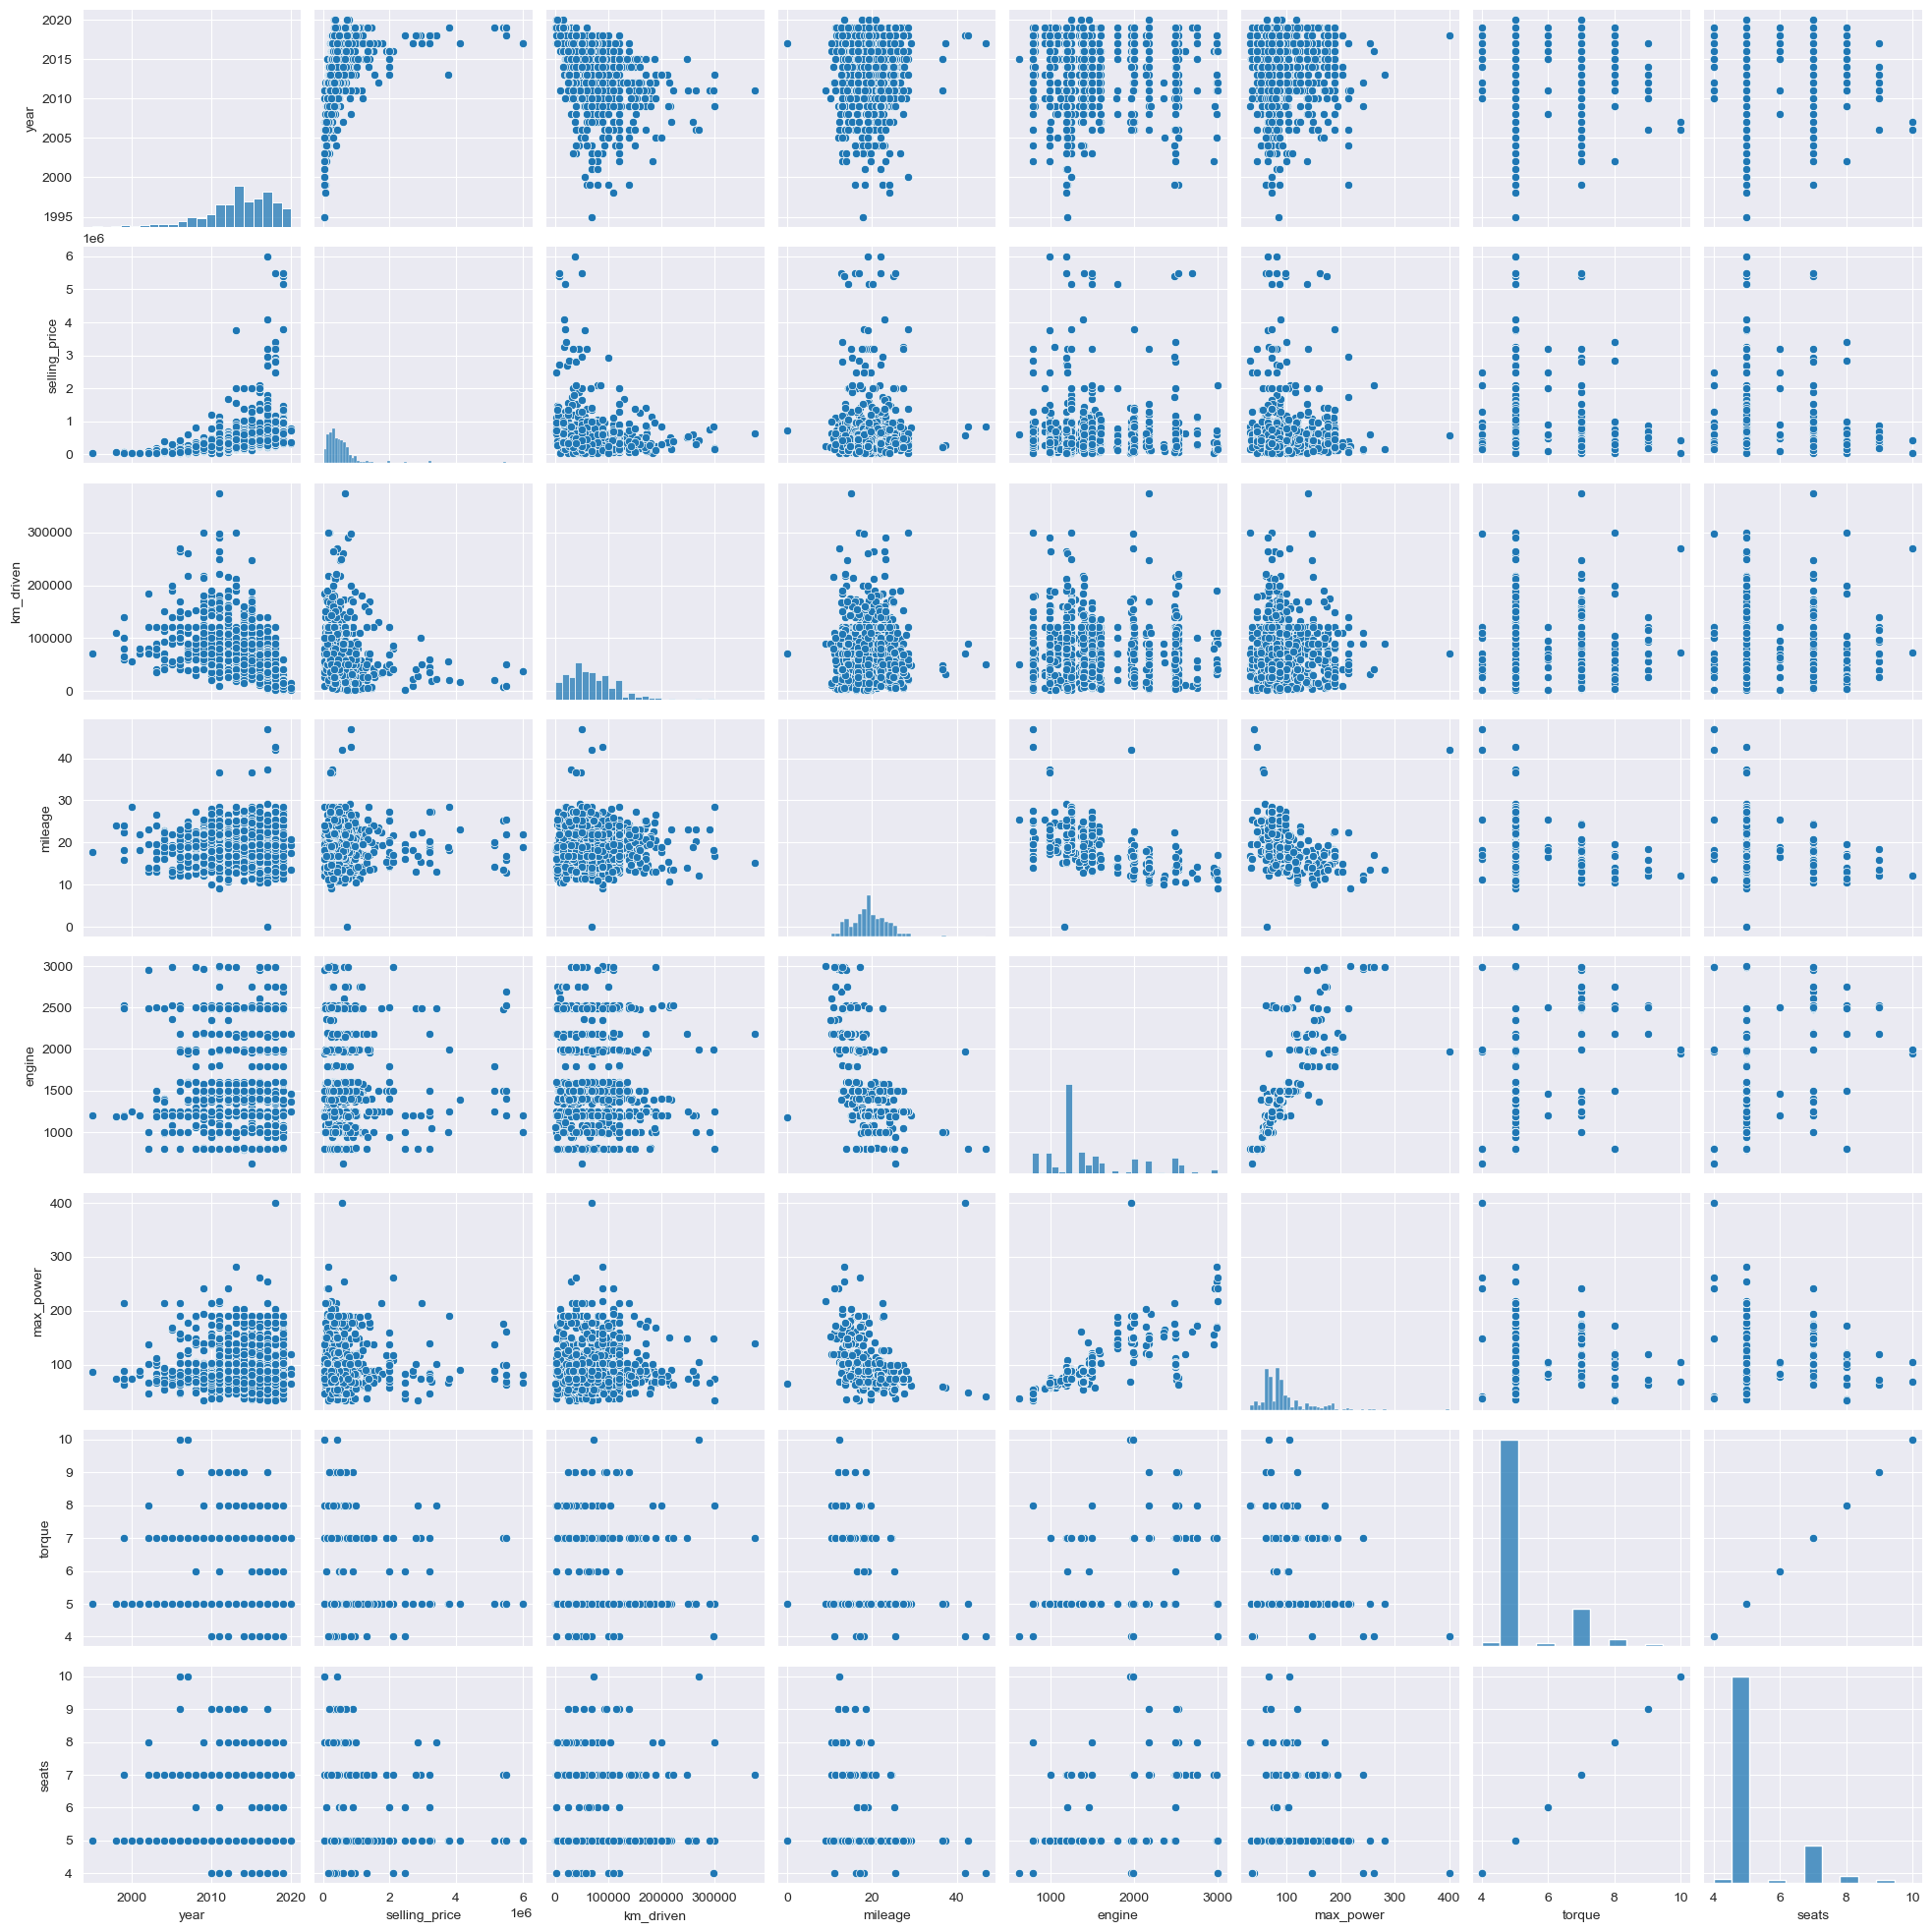

In [56]:
sns.pairplot(df_test)
plt.show()

1.Можно ли предположить на основе распределений связь признаков с целевой переменной? - `Да, можно использовать распределения признаков для того, чтобы предположить связь между признаками и целевой переменной`
 
2.Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков? - `Да, на основе распределений признаков и целевой переменной можно выдвигать гипотезы о возможных корреляциях между признаками, например с ростом объема двигателя и мозности цена автомобилей растёт, а при увеличении пробега падает`

3.Похожими ли оказались совокупности при разделении на трейн и тест? -  `Да, похожи`

### **Задание 7 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)


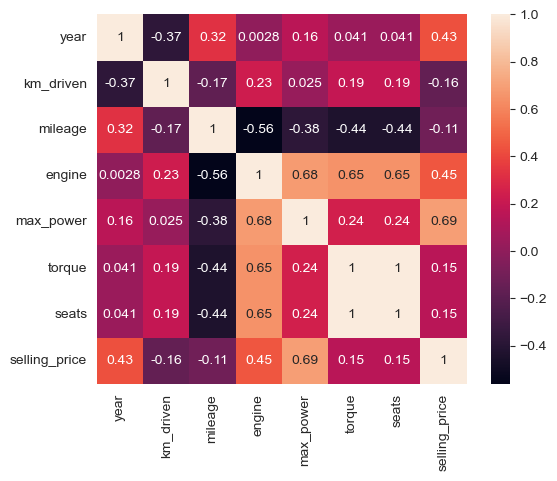

In [57]:
corr_matrix = df_train.corr(numeric_only=True)

sns.heatmap(corr_matrix, square=True, annot=True)
plt.show()

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?

1.Какие 2 признака наименее скоррелированы между собой? - `year и engine`

2.Между какими наблюдается довольно сильная положительная линейная зависимость? - `max_power и engine; torque и engine, seats и engine; max_power и selling_price`

3.Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи? - `корреляция между year и km_driven составляет -0.37. Я бы не стал сильно на этом настаивать)`

### **Бонус (0.5 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их **и поясните.**

interval columns not set, guessing: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'selling_price']


/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


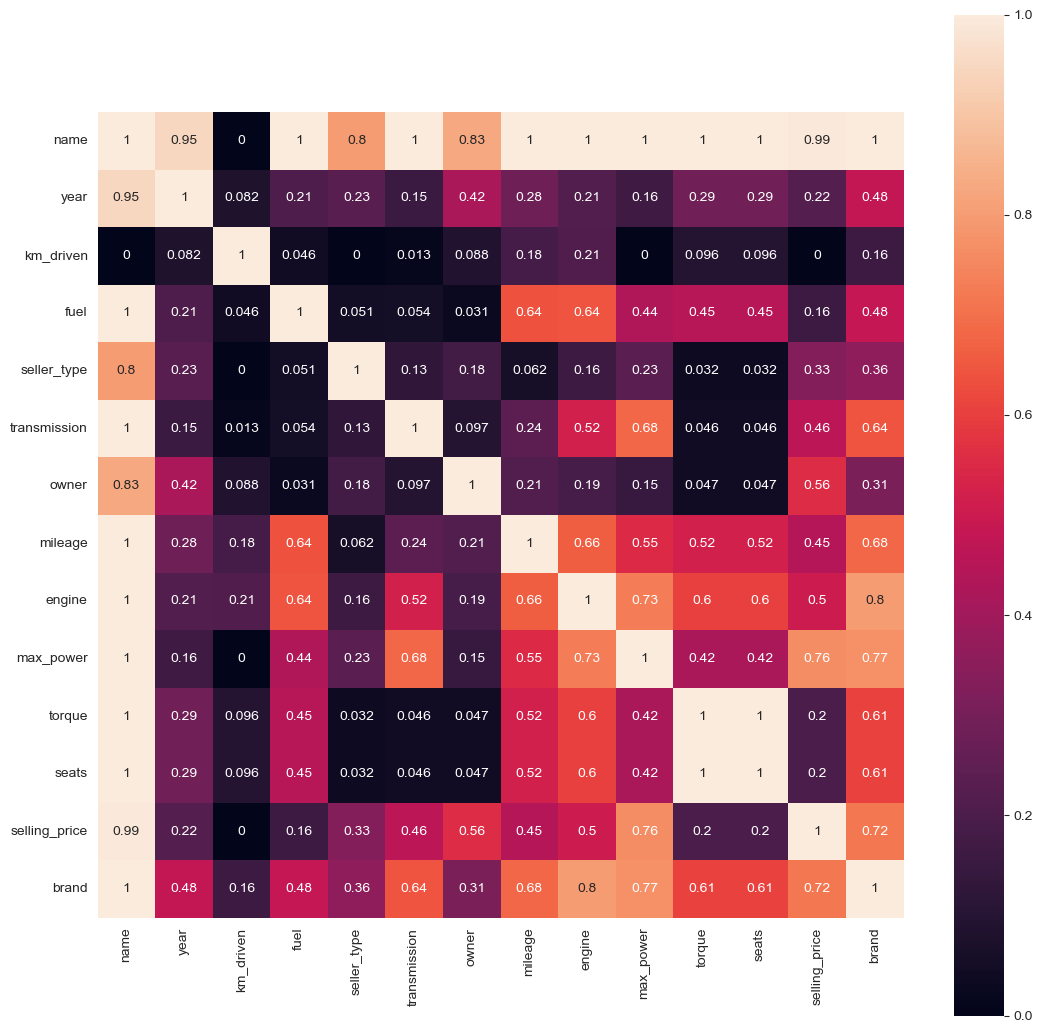

In [107]:
import phik
phik_matrix = df_train.phik_matrix()
plt.figure(figsize=(13, 13))
sns.heatmap(phik_matrix, square=True, annot=True)
plt.show()

# **Часть 2 | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.25 балла;

### **Задание 8 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [ ]:
y_train = df_train['selling_price']
X_train = df_train.select_dtypes(exclude=object).drop(['selling_price'], axis=1)

In [ ]:
assert X_train.shape == (5840, 7)  # 7 и 10 так как не был удален torque, а был обработан

In [59]:
y_test = df_test['selling_price']
X_test = df_test.select_dtypes(exclude=object).drop(['selling_price'], axis=1)

In [60]:
assert X_test.shape == (1000, 7)

### **Задание 9 (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train: R2: {train_r2}, MSE: {train_mse}")
print(f"Test: R2: {test_r2}, MSE: {test_mse}")

# Модель линейной регрессии имеет хорошее качество на тренировочных данных R2 около 0.6,
# но на тестовых данных она демонстрирует плохие результаты отрицательное R2 и большое значение MSE, 
# что свидетельствует о переобучении.

Train: R2: 0.593313772133494, MSE: 116571864588.69211
Test: R2: -0.17802675621286723, MSE: 677163418777.2843


### **Задание 10 (0.15 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

lr_scaler = LinearRegression()

lr_scaler.fit(X_train_scaler, y_train)

y_train_pred_scaler = lr_scaler.predict(X_train_scaler)
y_test_pred_scaler = lr_scaler.predict(X_test_scaler)

train_r2_scaler = r2_score(y_train, y_train_pred_scaler)
train_mse_scaler = mean_squared_error(y_train, y_train_pred_scaler)

test_r2_scaler = r2_score(y_test, y_test_pred_scaler)
test_mse_scaler = mean_squared_error(y_test, y_test_pred_scaler)

print(f"Train: R2: {train_r2_scaler}, MSE: {train_mse_scaler}")
print(f"Test: R2: {test_r2_scaler}, MSE: {test_mse_scaler}")

Train: R2: 0.5933104237011259, MSE: 116572824377.78221
Test: R2: -0.17775602799152912, MSE: 677007796464.842


### **Задание 11 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [63]:
for i, coef in enumerate(lr_scaler.coef_):
    print(f"Признак {i + 1}: {coef}")

most_important_feature_name = X_train.columns[max(range(len(lr_scaler.coef_)), key=lambda x: abs(lr_scaler.coef_[x]))]
print('Наиболее важный признак:', most_important_feature_name)

# По предыдушему анализу данных не сказал бы, что это самый важный признак, возможно вмешалась медиана с множеством изначанльных null данного столбца

Признак 1: 153004.106422397
Признак 2: -44040.69528884665
Признак 3: 29147.619575986373
Признак 4: 60012.650877070846
Признак 5: 324171.422306934
Признак 6: -9.295308231535569e+17
Признак 7: 9.295308231535333e+17
Наиболее важный признак: torque


### **Задание 12 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [64]:
from sklearn.linear_model import Lasso

lasso = Lasso()

lasso.fit(X_train_scaler, y_train)

y_pred_train_lasso = lasso.predict(X_train_scaler)
y_pred_test_lasso = lasso.predict(X_test_scaler)

train_r2_scaler = r2_score(y_train, y_pred_train_lasso)
train_mse_scaler = mean_squared_error(y_train, y_pred_train_lasso)

test_r2_scaler = r2_score(y_test, y_pred_test_lasso)
test_mse_scaler = mean_squared_error(y_test, y_pred_test_lasso)

print(f"Train: R2: {train_r2_scaler}, MSE: {train_mse_scaler}")
print(f"Test: R2: {test_r2_scaler}, MSE: {test_mse_scaler}")

# Качесвто такое же как и на линейной регрессии: на тренировочных данных R2 около 0.6,
# но на тестовых данных она демонстрирует плохие результаты отрицательное R2 и большое значение MSE, 
# что свидетельствует о переобучении.

Train: R2: 0.5933137720983999, MSE: 116571864598.75143
Test: R2: -0.17802470722256003, MSE: 677162240959.1455


In [65]:
for i, coef in enumerate(lasso.coef_):
    print(f"Признак {i + 1}: {coef}")

# Lasso-регрессия не занулила признаки, возможно из-за отсутствия малого коэффициента, малозначимого веса у перменных

Признак 1: 152737.29696757472
Признак 2: -44056.5858775444
Признак 3: 29478.791968292404
Признак 4: 58977.17422234379
Признак 5: 324865.5633952852
Признак 6: -22376.576296701965
Признак 7: -2.423990262697821e-11


### **Задание 13 Финальный рывок (0.5 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [66]:
from sklearn.model_selection import GridSearchCV

lasso = Lasso()

param_grid = {'alpha': [0.01, 0.1, 0.25, 0.5, 0.6, 0.7]}

grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')

grid_search.fit(X_train_scaler, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

best_coefs = best_model.coef_

n_models_trained = 10 * len(param_grid['alpha'])

zeroed_features = [lasso.coef_[i] for i, coef in enumerate(best_coefs) if coef == 0 or coef == -0.0]

print(f"Количество обученных моделей: {n_models_trained}")
print(f"Лучший коэффициент регуляризации (alpha): {best_alpha}")
print(f"Зануленные признаки: {zeroed_features}")

Количество обученных моделей: 60
Лучший коэффициент регуляризации (alpha): 0.7
Зануленные признаки: []


**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [103]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()

param_grid = {'alpha': [0.01, 0.1, 0.25, 0.5, 0.6, 0.7], 'l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.6, 0.7]}

grid_search_elastic = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=10,
                                   scoring='neg_mean_squared_error')

grid_search_elastic.fit(X_train_scaler, y_train)

best_params_elastic = grid_search_elastic.best_params_

num_models = 10 * len(param_grid['alpha']) * len(param_grid['l1_ratio'])
best_alpha = best_params_elastic['alpha']
best_l1_ratio = best_params_elastic['l1_ratio']

print(f"Количество обученных моделей: {n_models_trained}")
print(f"Лучший коэффициент регуляризации (alpha): {best_alpha}")
print(f"Лучший параметр l1_ratio: {best_l1_ratio}")


elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.01)

elastic_net.fit(X_train_scaler, y_train)

y_pred_train_elastic_net = elastic_net.predict(X_train_scaler)
y_pred_test_elastic_net = elastic_net.predict(X_test_scaler)

test_r2_scaler = r2_score(y_test, y_pred_test_elastic_net)
test_mse_scaler = mean_squared_error(y_test, y_pred_test_elastic_net)

print(f"Train: R2: {train_r2_scaler}, MSE: {train_mse_scaler}")
print(f"Test: R2: {test_r2_scaler}, MSE: {test_mse_scaler}")
     

/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.971e+13, tolerance: 1.605e+11
  model = cd_fast.enet_coordinate_descent(
/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e+13, tolerance: 1.632e+11
  model = cd_fast.enet_coordinate_descent(
/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

Количество обученных моделей: 130
Лучший коэффициент регуляризации (alpha): 0.25
Лучший параметр l1_ratio: 0.7
Train: R2: 0.5933137720983999, MSE: 116571864598.75143
Test: R2: -0.17221746268756455, MSE: 673824070970.8547


# **Часть 3| Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.75 основных балла и 0.25 бонусных.


### **Задание 14 (0.1 балла)** Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

В этом домашнем задании мы предлагаем удалить его.

**Ваша задача:**
- [ ] Удалить столбец`name`

In [68]:
X_train_cat = df_train.drop(['name'], axis=1)
X_test_cat = df_test.drop(['name'], axis=1)

В другом случае, конечно, мы могли бы предобработать данный столбец. В качестве бонуса предлагаем вам придумать и реализовать алгоритм предобработки.

### **Бонус 0.5 балла**
- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [109]:
def extract_car_brand(name):
    brand = name.split()[0]
    return brand


df_train['brand'] = df_train['name'].apply(extract_car_brand)

df_test['brand'] = df_test['name'].apply(extract_car_brand)

assert df_train.shape == (5840, 14)

In [70]:
X_test_cat.describe(include='object')

fuel seller_type transmission        owner
count     1000        1000         1000         1000
unique       4           3            2            5
top     Diesel  Individual       Manual  First Owner
freq       534         837          877          623

### **Задание 15 (0.4 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования. Обратите внимание, что во избежание мультиколлинеарности следует избавиться от одного из полученных столбцов при кодировании каждого признака методом OneHot.

In [92]:
from sklearn.preprocessing import OneHotEncoder

# X_train_cat['seats'] = X_train_cat['seats'].astype('object')
# X_test_cat['seats'] = X_test_cat['seats'].astype('object')

hot_encoder = OneHotEncoder()

hot_encoded_train_df = pd.DataFrame(hot_encoder.fit_transform(X_train_cat.select_dtypes('object')).toarray(),
                                    columns=hot_encoder.get_feature_names_out(
                                        list(X_train_cat.select_dtypes('object').columns)))
hot_encoded_test_df = pd.DataFrame(hot_encoder.transform(X_test_cat.select_dtypes('object')).toarray(),
                                   columns=hot_encoder.get_feature_names_out(
                                       X_test_cat.select_dtypes('object').columns))

X_train_cat_hot_encoded =pd.concat([X_train_cat.select_dtypes(exclude='object').reset_index(drop=True), hot_encoded_train_df.reset_index(drop=True)], axis=1)
X_test_cat_hot_encoded =pd.concat([X_test_cat.select_dtypes(exclude='object').reset_index(drop=True), hot_encoded_test_df.reset_index(drop=True)], axis=1)

### **Задание 16 (0.25 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [101]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()

param_grid = {'alpha': np.logspace(-6, 6, 13)}

grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring='r2', n_jobs=-1)

grid_search.fit(X_train_cat_hot_encoded, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

best_coefs = best_model.coef_

n_models_trained = 10 * len(param_grid['alpha'])

zeroed_features = [lasso.coef_[i] for i, coef in enumerate(best_coefs) if coef == 0 or coef == -0.0]

print(f"Количество обученных моделей: {n_models_trained}")
print(f"Лучший коэффициент регуляризации (alpha): {best_alpha}")
print(f"Зануленные признаки: {zeroed_features}")


# Да, удалось улучшить качество

/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.78125e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.87241e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.80827e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.42077e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Количество обученных моделей: 130
Лучший коэффициент регуляризации (alpha): 1e-06
Зануленные признаки: []


/Users/aleksey.malysh/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.71147e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 17 (0.5 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [104]:
import numpy as np

def business_metric(y_true, y_pred):
    percentage_diff = np.abs((y_pred - y_true) / y_true)
    return np.mean(percentage_diff <= 0.1)

print('Linear:', business_metric(y_test, y_test_pred))
print('Lasso:', business_metric(y_test, y_pred_test_lasso))
print('ElasticNet:', business_metric(y_test, y_pred_test_elastic_net))

Linear: 0.106
Lasso: 0.106
ElasticNet: 0.106


Значение метрик всех моделей получилось одинаково. Для данной задачи думаю, что больше подойдет Lasso, подтому что применяется решуляризация, которая может улучшить показатель при других данных

# **Часть 5 (3 балла) | Реализация сервиса на FastAPI**

### **Задание 18 (3 балла)**


Cделайте с помощью FastAPI сервис, который с точки зрения пользователя реализует две функции:

1. на вход в формате json подаются признаки одного объекта, на выходе сервис выдает предсказанную стоимость машины
2. на вход подается csv-файл с признаками тестовых объектов, на выходе получаем файл с +1 столбцом - предсказаниями на этих объектах

С точки зрения реализации это означает следующее:
- средствами pydantic должен быть описан класс базового объекта
- класс с коллецией объектов
- метод post, который получает на вход один объект описанного класса
- метод post, который получает на вход коллекцию объектов описанного класса

Шаблон для сервисной части дан ниже. Код необходимо дополнить и оформить в виде отдельного .py-файла.

In [ ]:
from typing import List

import category_encoders as ce
import numpy as np
import pandas as pd
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from joblib import load


def transform_data(dataset):
    dataset.loc[dataset['max_power'] == ' bhp', 'max_power'] = np.nan
    dataset.loc[dataset['max_power'] == '0', 'max_power'] = np.nan
    dataset['mileage'] = dataset['mileage'].apply(lambda x: (
        float(x.split(' ')[0]) if x.split(' ')[1] == 'kmpl' else float(
            x.split(' ')[0]) * 1.4) if type(x) != float else x)
    dataset['engine'] = dataset['engine'].apply(lambda x: float(x.split(' ')[0]) if type(x) != float else x)
    dataset['max_power'] = dataset['max_power'].apply(lambda x: float(x.split(' ')[0]) if type(x) != float else x)
    dataset['name'] = dataset['name'].apply(lambda x: x.split(' ')[0])
    return dataset


def fill_NA(dataset, train_median_mileage, train_median_engine, train_median_max_power, train_median_seats):
    dataset['mileage'] = dataset['mileage'].fillna(train_median_mileage)
    dataset['engine'] = dataset['engine'].fillna(train_median_engine)
    dataset['max_power'] = dataset['max_power'].fillna(train_median_max_power)
    dataset['seats'] = dataset['seats'].fillna(train_median_seats)
    dataset['seats'] = dataset['seats'].astype('object')
    return dataset


df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
y_train = df_train['selling_price']
X_train = transform_data(df_train.drop(['selling_price', 'torque'], axis=1))
train_median_mileage = X_train['mileage'].median()
train_median_engine = X_train['engine'].median()
train_median_max_power = X_train['max_power'].median()
train_median_seats = X_train['seats'].median()

X_train['mileage'] = X_train['mileage'].fillna(train_median_mileage)
X_train['engine'] = X_train['engine'].fillna(train_median_engine)
X_train['max_power'] = X_train['max_power'].fillna(train_median_max_power)
X_train['seats'] = X_train['seats'].fillna(train_median_seats)
X_train['seats'] = X_train['seats'].astype('object')

tgt_enc = ce.TargetEncoder(cols=['name'], smoothing=15)
tgt_enc.fit(X_train, y_train)
X_train = tgt_enc.transform(X_train)

hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
hot_encoded_train = hot_encoder.fit_transform(X_train.select_dtypes('object'))
hot_encoded_train_df = pd.DataFrame(hot_encoded_train,
                                columns=hot_encoder.get_feature_names_out(
                                    list(X_train.select_dtypes('object').columns)))
X_train_hot_encoded = pd.concat([X_train.select_dtypes(exclude='object').reset_index(drop=True)
                                , hot_encoded_train_df.reset_index(drop=True)], axis=1)

scaler = StandardScaler()
scaler.fit(X_train_hot_encoded)
X_train_scaler = pd.DataFrame(scaler.transform(X_train_hot_encoded), columns=X_train_hot_encoded.columns)

model = load('model.pkl')

app = FastAPI()


class Item(BaseModel):
    name: str
    year: int
    selling_price: int
    km_driven: int
    fuel: str
    seller_type: str
    transmission: str
    owner: str
    mileage: str
    engine: str
    max_power: str
    torque: str
    seats: float


class Items(BaseModel):
    objects: List[Item]


@app.post("/predict_item")
def predict_item(item: Item) -> float:
    input_data = pd.DataFrame([item.dict()]).drop(['selling_price', 'torque'], axis=1)

    input_data['mileage'] = input_data['mileage'].fillna(train_median_mileage)
    input_data['engine'] = input_data['engine'].fillna(train_median_engine)
    input_data['max_power'] = input_data['max_power'].fillna(train_median_max_power)
    input_data['seats'] = input_data['seats'].fillna(train_median_seats)
    input_data['seats'] = input_data['seats'].astype('object')

    data = transform_data(input_data)
    
    data = tgt_enc.transform(data)
    
    hot_encoded_data = hot_encoder.transform(data.select_dtypes('object'))
    hot_encoded_test_df = pd.DataFrame(hot_encoded_data,
                                   columns=hot_encoder.get_feature_names_out(data.select_dtypes('object').columns))
    data_cat_hot_encoded = pd.concat(
        [data.select_dtypes(exclude='object').reset_index(drop=True), hot_encoded_test_df.reset_index(drop=True)],
        axis=1)
    data_cat_hot_encoded_scal = pd.DataFrame(scaler.transform(data_cat_hot_encoded), columns=data_cat_hot_encoded.columns)
    
    predicted_price = model.predict(data_cat_hot_encoded_scal.values)
    return float(round(np.e ** predicted_price[0], 0))


@app.post("/predict_items")
def predict_items(items: Items) -> List[float]:
    input_data = items.dict()
    input_data = pd.DataFrame(input_data['objects'])
    input_data = input_data.drop(['selling_price', 'torque'], axis=1)

    input_data['mileage'] = input_data['mileage'].fillna(train_median_mileage)
    input_data['engine'] = input_data['engine'].fillna(train_median_engine)
    input_data['max_power'] = input_data['max_power'].fillna(train_median_max_power)
    input_data['seats'] = input_data['seats'].fillna(train_median_seats)
    input_data['seats'] = input_data['seats'].astype('object')

    data = transform_data(input_data)
    
    data = tgt_enc.transform(data)
    hot_encoded_data = hot_encoder.transform(data.select_dtypes('object'))
    hot_encoded_test_df = pd.DataFrame(hot_encoded_data,
                                   columns=hot_encoder.get_feature_names_out(data.select_dtypes('object').columns))
    data_cat_hot_encoded = pd.concat(
        [data.select_dtypes(exclude='object').reset_index(drop=True), hot_encoded_test_df.reset_index(drop=True)],
        axis=1)

    data_cat_hot_encoded_scal = pd.DataFrame(scaler.transform(data_cat_hot_encoded), columns=data_cat_hot_encoded.columns)

    predicted_prices = model.predict(data_cat_hot_encoded_scal.values)

    return [float(round(price, 0)) for price in np.e ** predicted_prices]

if __name__ == "__main__":
    uvicorn.run("main:app", host="127.0.0.1", port=8000, reload=True)
